Description: This script creates Figs. 17c,A2, and A3.

In [1]:
import glob
import os
import warnings
from datetime import datetime

import cmocean.cm as cmo
import dask
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import seaborn
import xarray as xr
from matplotlib import patches
from skimage import io
from skimage.measure import label, regionprops, regionprops_table

# load custom colormaps
from may19_2013_obs_analysis import cmap_extent_density_b13, cmap_footprint_b13
from may19_2013_obs_analysis.zdr_flash_panel_plots import plot_flash_zdr
from may19_2013_obs_analysis.utils import npdt_to_datetime
from matplotlib import dates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from may19_2013_obs_analysis.utils import my_annotate

seaborn.set(style="ticks")


plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2

In [2]:
# after manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

obj_interest = [
    [3],
    [2],
    [2],
    [1, 2],
    [3],
    [1],
    [2, 3],
    [2, 3, 4, 5],
    [5, 6],
    [2],
    [4, 5],
    [3, 4],
    [2, 3],
    [2, 3],
    [5, 6],
    [3],
    [4, 5],
    [3, 4],
    [3, 4],
    [1, 2],
    [3, 4],
    [6, 7, 9],
    [1, 2, 3],
    [3, 4, 5],
    [2, 3],
    [2, 3, 4, 5],
    [1, 2, 3],
    [1, 2],
    [2, 3],
    [2, 3],
    [1, 4],
    [1, 2],
    [1, 2],
    [2, 3],
    [1, 2],
    [3, 4, 5],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [3]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/zdr/direct_array/*tiff")
)

# rad_files = sorted(glob.glob('path/to/KTLX_data/*V06'))
rad_files = sorted(
    glob.glob("path/to/KTLX_files/*V06")
)
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [4]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for zdr column objects
# NOTE: These zdr column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader.

segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/zdr/direct_array/*.tiff")
)


final_zdr_df = pd.DataFrame()
for i in range(len(segmented_files)):

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label","equivalent_diameter"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_zdr_df = final_zdr_df.append(df_sel,)

In [5]:
final_zdr_df

,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,label,equivalent_diameter
time,,,,,,,,,
2013-05-19 20:02:36,0,32,15,8,57,28,2600,3,10.920988
2013-05-19 20:06:52,0,43,19,11,70,37,5346,2,11.593926
2013-05-19 20:11:07,0,38,25,8,78,41,5120,2,12.960907
2013-05-19 20:15:23,0,68,36,4,85,45,612,1,7.069538
2013-05-19 20:15:23,0,33,27,8,67,42,4080,2,12.213775
...,...,...,...,...,...,...,...,...,...
2013-05-19 22:27:38,0,113,222,7,134,235,1911,2,9.774699
2013-05-19 22:31:53,0,135,186,4,141,193,168,3,5.390202
2013-05-19 22:31:53,0,116,228,5,141,241,1625,4,9.821120


### Here's a small twist

regionprops_table() returns the properties for the entire array. So, in our case, when we used seg (segmented array; shape = (15,241,241)) </br>
it returned a one-size fits all bbox with the largest size (after iterating through all z-levels). Similarly, bbox_area gives the area of the </br>
entire bbox (or rather all pixels within the 3D bbox identified this way)

> Here's a workaround: We want the accurate bounding box at each z-level i.e., the box should only enclose the object at that z-level </br>
without accounting for whatever the bbox size is at altitudes above or below it


In [6]:
# create a list of altitudes to be fed as pandas index
# the values here were known to us because of segmentation z-level limits
alts = np.arange(4000, 11500, 500)

mega_tt = pd.DataFrame()
for i in range(len(segmented_files)):
    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    tt = pd.DataFrame()
    for j in range(
        seg.shape[0]
    ):  # loop for moving through all z-levels (4000 to 11000 m)

        try:  # fails when there is no data to be measured in the segmented file

            # create a temporary dataframe to store region props at each z-level
            tmp = pd.DataFrame(
                regionprops_table(
                    seg[j, :, :], properties=["bbox", "bbox_area", "area", "equivalent_diameter","label"]
                )
            )

            try:  # fails when no pixel with label of interest is left at a certain altitude level

                for k in range(
                    len(obj_interest[i])
                ):  # loop to account for all segmented objects (if multiple objects exist in a segmented file)

                    # filter out the row from tmp dataframe that corresponds to a particular object label
                    tmp1 = tmp[tmp["label"] == obj_interest[i][k]]

                    # create a multi-index dataframe to store info about time, obj label, and z-level of region props
                    # this will enable us to calculate ZDR/KDP intensity within accurately identified bbox regions at each z-level
                    tmp2 = pd.DataFrame(
                        tmp1.iloc[:, :7].values,
                        index=[[dt_tmpstmps[i]], [obj_interest[i][k]], [alts[j]]],
                        columns=tmp.columns[:7],
                    )
                    
                    # equivalent diameter is float making the dtype for all columns in the dataframe as float
                    # bbox coordinates however are expected to have integer values in the code below
                    # converting all relevant column dtypes as int 
                    tmp2 = tmp2.astype({'bbox-0': 'int','bbox-1': 'int','bbox-2': 'int','bbox-3': 'int'})
                    tt = tt.append(tmp2)
            except:
                pass
        except IndexError:
            pass

    # finally, append dataframe at each vertical level to obtain one dataframe per time (for all objects and z-levels)
    mega_tt = mega_tt.append(tt)

# rename indices of final dataframe for more clarity to user
mega_tt.index.names = ["time", "label", "altitude"]

# Next, we want to reorder the indices to have all region props for each object listed out sequentially
# before proceeding with the next object (if there exists any) in the same segmented file

# check out how max/min function works on nested lists at the following link
# https://stackoverflow.com/questions/34050113/how-does-the-min-max-function-on-a-nested-list-work
final_bbox_data = mega_tt.reindex(np.arange(max(max(obj_interest))), level=1)

#### The patch overlay obviously appears to have an offset 

because the patch geometry was calculated from PyART gridded segmentation files

In [7]:
# function to calculate statistical properties of actual ZDR/KDP values within identified objects from segmented output


def zdr_intensity(grid_data, final_bbox_data, dt, field):
    """
    
    Input:
    --------
    grid_data (xarray dataset): full gridded radar data
    final_bbox_data (pandas dataframe): full bounding box data 
    dt (datetime object): datetime at which radar properties need to be calculated
    field (str) : field of choice from radar data 
            (CAUTION: Not every radar has fields named as per 88D convention)
            
    Returns:
    --------
    xarray dataset with polarimetric field data within each object 
    of interest at all the z-levels
    """
    bbox_data = final_bbox_data.loc[dt]
    radar_data = grid_data.sel(time=str(dt))
    field_data = radar_data[field]

    if len(np.unique(bbox_data.index.get_level_values("label"))) == 1:

        zvals = bbox_data.index.get_level_values("altitude")
        final_field_data = []

        #         access data corresponding to multiindex levels in pandas dataframes using query
        #         idea source: https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
        for zval in zvals:
            left_x = (
                field_data.sel(z=zval)["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            left_y = (
                field_data.sel(z=zval)["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )

            width = (
                field_data.sel(z=zval)["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                .data[0]
                - field_data["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            height = (
                field_data.sel(z=zval)["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                .data[0]
                - field_data["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )

            field_data_alt = field_data.sel(
                x=slice(left_x, left_x + width),
                y=slice(left_y, left_y + height),
                z=zval,
            )
            final_field_data.append(field_data_alt)

        return xr.concat(final_field_data, dim="z", join="outer")

    elif len(np.unique(bbox_data.index.get_level_values("label"))) > 1:
        labels = np.unique(bbox_data.index.get_level_values("label"))
        tmp_ds = xr.Dataset()

        for label in labels:
            sub_box_data = bbox_data.query(f"label == {label}")
            zvals = sub_box_data.index.get_level_values("altitude")

            final_field_data = []

            #         access data corresponding to multiindex levels in pandas dataframes using query
            #         idea source: https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
            for zval in zvals:
                left_x = (
                    field_data.sel(z=zval)["x"]
                    .isel(
                        x=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1
                    )  # bbox coordinates are defined on an open interval [low,high); so subtracting 1
                    .data[0]
                )
                left_y = (
                    field_data.sel(z=zval)["y"]
                    .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                    .data[0]
                )

                width = (
                    field_data.sel(z=zval)["x"]
                    .isel(x=sub_box_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                    .data[0]
                    - field_data["x"]
                    .isel(x=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                    .data[0]
                )

                height = (
                    field_data.sel(z=zval)["y"]
                    .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                    .data[0]
                    - field_data["y"]
                    .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                    .data[0]
                )

                field_data_alt = field_data.sel(
                    x=slice(left_x, left_x + width),
                    y=slice(left_y, left_y + height),
                    z=zval,
                )
                final_field_data.append(field_data_alt)

            xr_data = xr.concat(final_field_data, dim="z", join="outer").squeeze()
            tmp_ds[f"zdrcol_{label}"] = (
                (f"z_{label}", f"y_{label}", f"x_{label}"),
                xr_data,
            )
            tmp_ds.coords[f"z_{label}"] = (f"z_{label}", zvals)
            tmp_ds.coords[f"y_{label}"] = (f"y_{label}", xr_data.y)
            tmp_ds.coords[f"x_{label}"] = (f"x_{label}", xr_data.x)

        return tmp_ds

### Filter dual pol properties 

>Choose whether you want **mean or max** ZDR value at each z-level 

In [9]:
# load gridded KTLX data 
data = xr.open_mfdataset(
    "path/to/KTLX_data/gridded_ktlx/*.nc",
    parallel=True,
)
data

<xarray.Dataset>
Dimensions:                      (nradar: 1, time: 42, x: 241, y: 241, z: 31)
Coordinates:
  * time                         (time) datetime64[ns] 2013-05-19T20:02:36.05...
  * x                            (x) float64 -7.5e+04 -7.45e+04 ... 4.5e+04
  * y                            (y) float64 0.0 500.0 ... 1.195e+05 1.2e+05
  * z                            (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
Dimensions without coordinates: nradar
Data variables: (12/21)
    origin_latitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_longitude             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_altitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    projection                   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ProjectionCoordinateSystem   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    radar_latitude               (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...                           ...
    cross_correlation_ratio      (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    norm_coherent_power          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    unfolded_differential_phase  (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    phidp                        (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    kdp                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    ROI                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
Attributes:
    Conventions:         CF/Radial instrument_parameters
    version:             1.3
    title:               
    institution:         
    references:          
    source:              
    history:             
    comment:             
    instrument_name:     KTLX
    original_container:  NEXRAD Level II
    vcp_pattern:         12

In [10]:
zdr_prop_alt = []
for i in range(len(dt_tmpstmps)):
    zdr_col_data = zdr_intensity(
        data, final_bbox_data, str(dt_tmpstmps[i]), "differential_reflectivity"
    )
    
    try:
        zdr_col_data = zdr_col_data.where(zdr_col_data > 1)

        if isinstance(zdr_col_data, xr.DataArray):
            #         print(zdr_col_data)
            zdr_prop_alt.append(zdr_col_data.mean(dim=["x", "y"]))
        elif isinstance(zdr_col_data, xr.Dataset):
            var_names = list(zdr_col_data.data_vars.variables)
            for j in range(len(var_names)):
                var = var_names[j]
                var_data = zdr_col_data[var]
                dims = var_data.dims
                tmp = var_data.rename(dict(zip(dims, ("z", "y", "x"))))
                tmp = tmp.mean(dim=["x", "y"])
                tmp = tmp.assign_coords({"time": dt_tmpstmps[i]})
                tmp = tmp.expand_dims("time")
                #             print(tmp)
                zdr_prop_alt.append(tmp)

    except AttributeError:
        # fails when there is no zdr column data 
        pass

In [11]:
# concatenate list of dataarrays into a single dataarray
full_zdr_prop_alt_da = xr.concat(zdr_prop_alt, dim="time")

# convert dataarray to dataframe to plot data using seaborn
full_zdr_prop_alt = full_zdr_prop_alt_da.to_dataframe()
full_zdr_prop_alt = full_zdr_prop_alt.reset_index(level=["time", "z"])
# full_zdr_prop_alt

# add hue column in the dataframe
full_zdr_prop_alt["hue"] = full_zdr_prop_alt["z"].astype("category")

full_zdr_prop_alt['hue'] = (full_zdr_prop_alt["z"]-4000).astype("category")
full_zdr_prop_alt.rename({'hue':'Height above FZL (m)'},axis=1,inplace=True)


full_zdr_prop_alt

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,z,time,differential_reflectivity,Height above FZL (m)
0,4000.0,2013-05-19 20:02:36.054999999,2.154295,0.0
1,4000.0,2013-05-19 20:06:52.065000000,1.979614,0.0
2,4000.0,2013-05-19 20:11:07.271999999,2.525284,0.0
3,4000.0,2013-05-19 20:15:23.000000000,3.297743,0.0
4,4000.0,2013-05-19 20:15:23.000000000,2.079807,0.0
...,...,...,...,...
809,9000.0,2013-05-19 22:27:38.000000000,NaN,5000.0
810,9000.0,2013-05-19 22:31:53.000000000,NaN,5000.0
811,9000.0,2013-05-19 22:31:53.000000000,NaN,5000.0
812,9000.0,2013-05-19 22:31:53.000000000,NaN,5000.0


/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


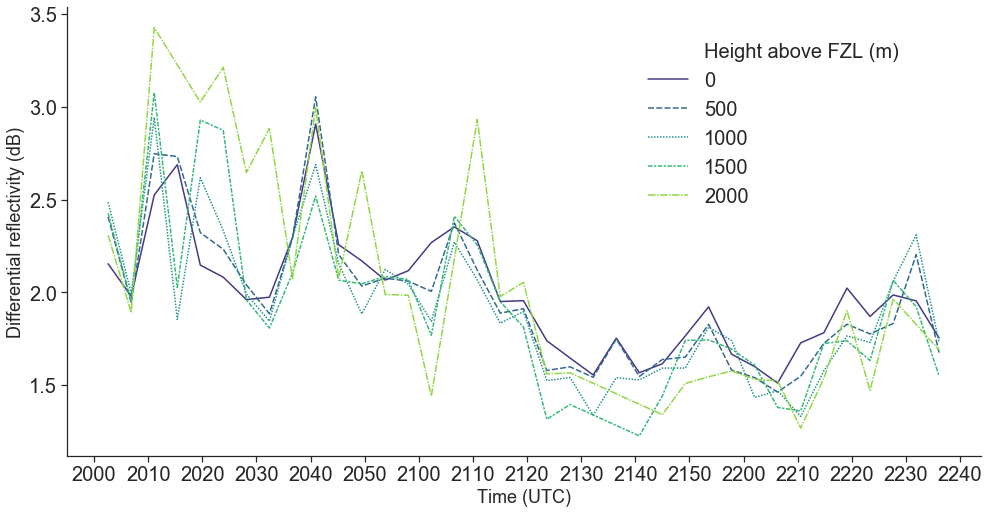

In [12]:
# fig = plt.figure(figsize=(12,12))
g = seaborn.relplot(
    data=full_zdr_prop_alt,
    kind="line",
    hue="Height above FZL (m)",
    hue_order=[0, 500, 1000, 1500, 2000],
    x="time",
    y="differential_reflectivity",
    palette="viridis",
    style="Height above FZL (m)",
    style_order=[0, 500, 1000, 1500, 2000],
    height=5,
    aspect=1,
    facet_kws=dict(sharex=False),
    ci =None
    #     markers=True
)
g.fig.set_figwidth(35)
g.fig.set_figheight(8)
g.ax.xaxis.set_major_formatter(dates.DateFormatter("%H%M"))
g.ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))

leg = g._legend
leg.set_bbox_to_anchor([0.25, 0.85])  # coordinates of lower left of bounding box
leg._loc = 2  # if required you can set the loc

g.set_ylabels('Differential reflectivity (dB)')
g.set_xlabels('Time (UTC)')
# plt.tight_layout()
plt.show()

### Let's quickly plot the equivalent diameter to get a sense of ZDR column widths

In [13]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 28
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 22
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 28

In [14]:
# Load data from lasso analysis generated flash stats csv file using lmatools
lasso = '../data/interim/flash_stats.csv'

lasso_data = pd.read_csv(lasso, usecols=[0, 2])
lasso_data = lasso_data[0:-1]
lasso_data.columns = ['time', 'number']

lasso_data.index = pd.to_datetime(lasso_data['time'])
lasso_data = lasso_data.drop(columns=['time'])
lasso_data = lasso_data.rename({'number':'total flash rate'},axis=1)

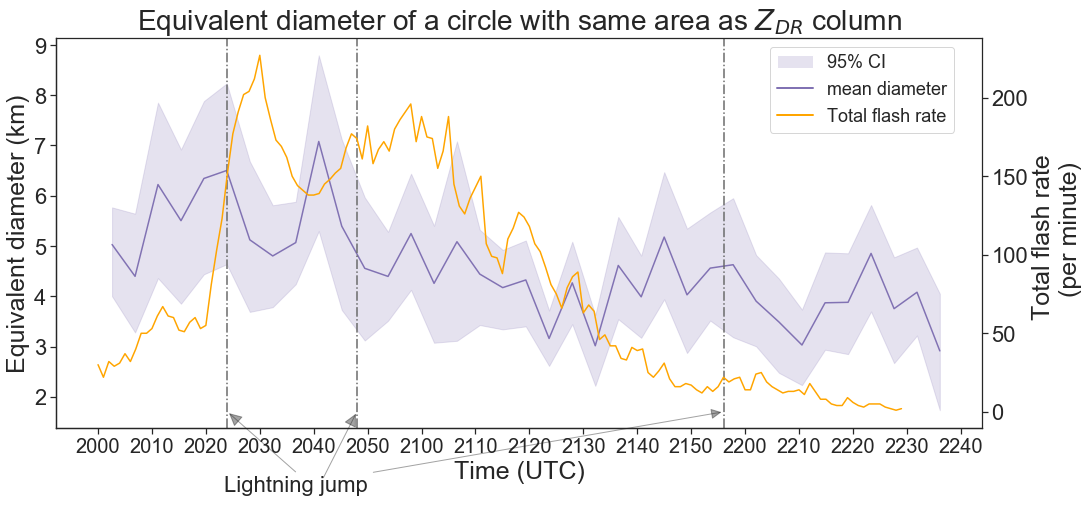

In [15]:
# fig = plt.figure(figsize=(12,12))

eq_dia_df = final_bbox_data.sort_index(level='altitude').reset_index('time')
eq_dia_df['equivalent_diameter'] = eq_dia_df['equivalent_diameter']*0.5

g = seaborn.relplot(
    data=eq_dia_df,
    kind="line",
#     hue="hue",
#     hue_order=[4000, 4500, 5000, 5500, 6000],
    x="time",
    y="equivalent_diameter",
    color='m',
#     palette="tab10",
#     style="hue",
#     style_order=[4000, 4500, 5000, 5500, 6000],
    height=5,
    aspect=1,
    facet_kws=dict(sharex=False),
#     ci = None,
#     markers=True,
#     dashes=True
)

g.fig.set_figwidth(20)
g.fig.set_figheight(8)
g.set_ylabels('Equivalent diameter (km)')
g.set_xticklabels(dt_tmpstmps)
g.set_xlabels('Time (UTC)')
g.ax.set_title('Equivalent diameter of a circle with same area as $Z_{DR}$ column')

g.ax.xaxis.set_major_formatter(dates.DateFormatter("%H%M"))
g.ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
# plt.legend(loc='upper right')

# g.add_legend()

# leg = g._legend
# leg.set_bbox_to_anchor([0.7, 1])  # coordinates of lower left of bounding box
# leg._loc = 2  # if required you can set the loc


ax2 = g.ax.twinx()

with pd.plotting.plot_params.use('x_compat', True):
    fr = ax2.plot(lasso_data,label='Total flash rate',c='orange')

ax2.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%H%M'))

ax2.set_ylabel('Total flash rate \n (per minute)')

legend_elements = [Patch(facecolor='#e5e2ef', label='95% CI'),
                   Line2D([0], [0], color='m', lw=2, label='mean diameter'),
                  Line2D([0], [0], color='orange', lw=2, label='Total flash rate'),
                  ]

g.ax.legend((legend_elements[0],legend_elements[1],legend_elements[2]),('95% CI','mean diameter','Total flash rate'),
            bbox_to_anchor=(0.48, 0.5, 0.5, 0.5), prop={'size': 18})

my_annotate(
    ax2,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 56, 0), 0),
        (datetime(2013, 5, 19, 20, 24, 0), 0),
        (datetime(2013, 5, 19, 20, 48, 0), 0),
    ],
    xycoords="data",
    xytext=(-500, -80),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", ec='k',alpha=0.4),
    fontsize=22,
)
g.ax.axvline(datetime(2013, 5, 19, 21, 56, 0), linestyle="-.", color="dimgrey")
g.ax.axvline(datetime(2013, 5, 19, 20, 24, 0), linestyle="-.", color="dimgrey")
g.ax.axvline(datetime(2013, 5, 19, 20, 48, 0), linestyle="-.", color="dimgrey")

### Let's also try plotting $Z_{DR}$ column volume at each z-level (grids with $Z_{DR}$ > 1dB only)

In [20]:
zdr_vol_alt = []
for i in range(len(dt_tmpstmps)):
    zdr_col_data = zdr_intensity(
        data, final_bbox_data, str(dt_tmpstmps[i]), "differential_reflectivity"
    )
    
    try:
        zdr_col_data = zdr_col_data.where(zdr_col_data > 1)

        if isinstance(zdr_col_data, xr.DataArray):
            #         print(zdr_col_data)
            zdr_vol_alt.append(zdr_col_data.count(dim=["x", "y"]) * 0.5**3)
        elif isinstance(zdr_col_data, xr.Dataset):
            var_names = list(zdr_col_data.data_vars.variables)
            for j in range(len(var_names)):
                var = var_names[j]
                var_data = zdr_col_data[var]
                dims = var_data.dims
                tmp = var_data.rename(dict(zip(dims, ("z", "y", "x"))))
                tmp = tmp.count(dim=["x", "y"]) * 0.5**3
                tmp = tmp.assign_coords({"time": dt_tmpstmps[i]})
                tmp = tmp.expand_dims("time")
                #             print(tmp)
                zdr_vol_alt.append(tmp)

    except AttributeError:
        # fails when there is no zdr column data 
        pass

In [21]:
# concatenate list of dataarrays into a single dataarray
full_zdr_vol_alt_da = xr.concat(zdr_vol_alt, dim="time")

# convert dataarray to dataframe to plot data using seaborn
full_zdr_vol_alt = full_zdr_vol_alt_da.to_dataframe()
full_zdr_vol_alt = full_zdr_vol_alt.reset_index(level=["time", "z"])
# full_zdr_prop_alt

# add hue column in the dataframe
full_zdr_vol_alt["hue"] = full_zdr_vol_alt["z"].astype("category")
full_zdr_vol_alt

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


,z,time,differential_reflectivity,hue
0,4000.0,2013-05-19 20:02:36.054999999,20.000,4000.0
1,4000.0,2013-05-19 20:06:52.065000000,21.750,4000.0
2,4000.0,2013-05-19 20:11:07.271999999,47.375,4000.0
3,4000.0,2013-05-19 20:15:23.000000000,12.000,4000.0
4,4000.0,2013-05-19 20:15:23.000000000,37.125,4000.0
...,...,...,...,...
809,9000.0,2013-05-19 22:27:38.000000000,NaN,9000.0
810,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0
811,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0
812,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0


Now, we want to sum up volumes of all ZDR column objects at a given altitude for a given time step

In [23]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 28
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 22
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 28

In [24]:
full_zdr_vol_alt = full_zdr_vol_alt.groupby(['z','time']).agg({'differential_reflectivity': sum}).reset_index()

In [25]:
full_zdr_vol_alt["Height above FZL (m)"] = (full_zdr_vol_alt["z"]-4000).astype("category")

In [26]:
from may19_2013_obs_analysis.utils import my_annotate

[Text(-500, -100, 'Lightning jump'),
 Text(0, 0, 'Lightning jump'),
 Text(0, 0, 'Lightning jump')]

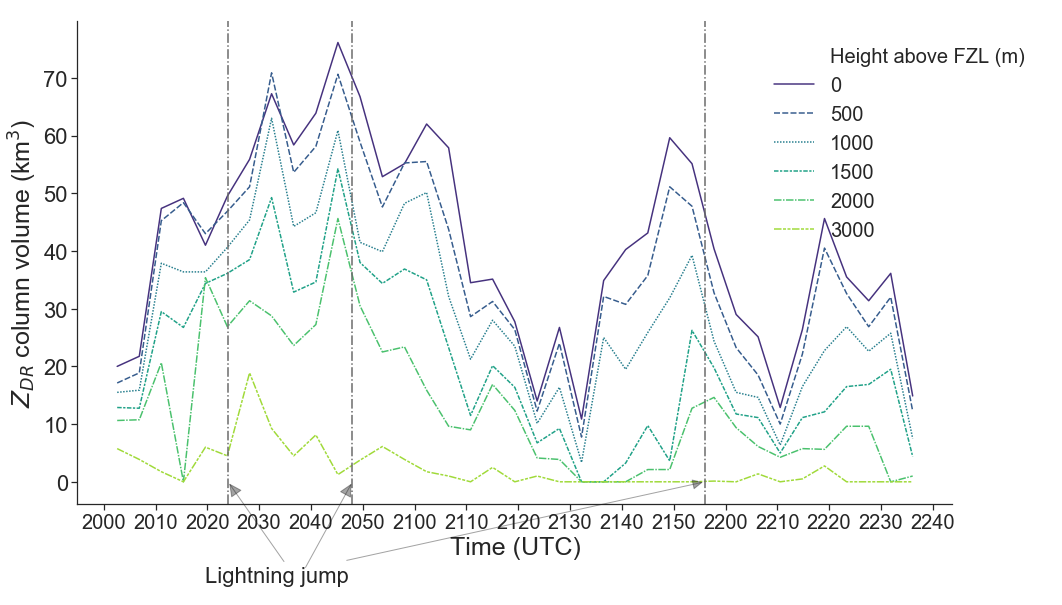

In [27]:
# fig = plt.figure(figsize=(12,12))
g = seaborn.relplot(
    data=full_zdr_vol_alt,
    kind="line",
    hue="Height above FZL (m)",
    hue_order=[0, 500, 1000, 1500, 2000, 3000],
    x="time",
    y="differential_reflectivity",
    palette="viridis",
    style="Height above FZL (m)",
    style_order=[0, 500, 1000, 1500, 2000, 3000],
    height=10,
    aspect=2.5,
    facet_kws=dict(sharex=False),
#     legend = False
    #     markers=True
)
g.fig.set_figwidth(15)
g.fig.set_figheight(8)
g.set_ylabels('$Z_{DR}$ column volume (km$^{3}$)')
g.set_xticklabels(dt_tmpstmps)
g.set_xlabels('Time (UTC)')

g.ax.xaxis.set_major_formatter(dates.DateFormatter("%H%M"))
g.ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
# plt.legend(loc='upper right')

leg = g._legend
leg.set_bbox_to_anchor([0.7, 1])  # coordinates of lower left of bounding box
leg._loc = 2  # if required you can set the loc

g.ax.axvline(datetime(2013, 5, 19, 21, 56, 0), linestyle="-.", color="dimgrey")
g.ax.axvline(datetime(2013, 5, 19, 20, 24, 0), linestyle="-.", color="dimgrey")
g.ax.axvline(datetime(2013, 5, 19, 20, 48, 0), linestyle="-.", color="dimgrey")

# ax2 = g.ax.twinx()
# ax2.plot(lasso_data,c='r',marker='*')

my_annotate(
    g.ax,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 56, 0), 0),
        (datetime(2013, 5, 19, 20, 24, 0), 0),
        (datetime(2013, 5, 19, 20, 48, 0), 0),
    ],
    xycoords="data",
    xytext=(-500, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", ec='k',alpha=0.4),
    fontsize=22,
)

### KDP column volume

In [28]:
# after manual verification of all the KDP column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

# These are from new segmentation performed on kdp array on Nov 28, 2020
kdp_obj_interest = [
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [8],
    [4],
    [7],
    [3, 8],
    [3],
    [4],
    [3],
    [2],
    [4, 6],
    [2],
    [1],
    [2],
    [5],
    [5],
    [2, 3],
    [4],
    [4],
    [2],
    [1],
    [2],
    [3, 4],
    [2],
    [3, 4],
    [3],
    [3],
    [1],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [29]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

kdp_segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/kdp/direct_array/*tiff")
)

# rad_files = sorted(glob.glob('path/to/KTLX_data/*V06'))
rad_files = sorted(
    glob.glob("path/to/KTLX_data/*V06")
)
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [30]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for kdp column objects
# NOTE: These kdp column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader.

final_kdp_df = pd.DataFrame()
for i in range(len(kdp_segmented_files)):

    cell_seg_reader = io.imread(kdp_segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(kdp_obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_kdp_df = final_kdp_df.append(df_sel,)

In [31]:
# create a list of altitudes to be fed as pandas index
# the values here were known to us because of segmentation z-level limits
alts = np.arange(4000, 11500, 500)


mega_tt = pd.DataFrame()
for i in range(len(kdp_segmented_files)):
    cell_seg_reader = io.imread(kdp_segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    tt = pd.DataFrame()
    for j in range(seg.shape[0]):  # loop for moving through all z-levels (4000 to 11000 m)

        try:  # fails when there is no data to be measured in the segmented file

            # create a temporary dataframe to store region props at each z-level
            tmp = pd.DataFrame(
                regionprops_table(
                    seg[j, :, :], properties=["bbox", "bbox_area", "area", "label"]
                )
            )

            try:  # fails when no pixel with label of interest is left at a certain altitude level

                for k in range(
                    len(kdp_obj_interest[i])
                ):  # loop to account for all segmented objects (if multiple objects exist in a segmented file)

                    # filter out the row from tmp dataframe that corresponds to a particular object label
                    tmp1 = tmp[tmp["label"] == kdp_obj_interest[i][k]]

                    # create a multi-index dataframe to store info about time, obj label, and z-level of region props
                    # this will enable us to calculate ZDR/KDP intensity within accurately identified bbox regions at each z-level
                    tmp2 = pd.DataFrame(
                        tmp1.iloc[:, :6].values,
                        index=[[dt_tmpstmps[i]], [kdp_obj_interest[i][k]], [alts[j]]],
                        columns=tmp.columns[:6],
                    )
                    tt = tt.append(tmp2)
            except:
                pass
        except IndexError:
            pass
    

    # finally, append dataframe at each vertical level to obtain one dataframe per time (for all objects and z-levels)
    mega_tt = mega_tt.append(tt)



# rename indices of final dataframe for more clarity to user
mega_tt.index.names = ["time", "label", "altitude"]

# Next, we want to reorder the indices to have all region props for each object listed out sequentially
# before proceeding with the next object (if there exists any) in the same segmented file

# check out how max/min function works on nested lists at the following link
# https://stackoverflow.com/a/55846534/12538451
final_bbox_data_kdp = mega_tt.reindex(np.arange([max((y for y in x if y is not np.nan), default=np.nan) for x in zip(*kdp_obj_interest)][0]), level=1)

In [33]:
def dualpol_gt_thresh_vol(data,bbox_data,dt,field,threshold):
    zdr_anim_data = zdr_intensity(
        data, bbox_data, str(dt), field
        )

    zdr_anim_data = zdr_anim_data.where(zdr_anim_data > threshold)


    if isinstance(zdr_anim_data, xr.DataArray):  # when only one zdr obj is present
        vol = zdr_anim_data.squeeze().count(dim=['z','y','x']) * 0.5**3
        return np.array(vol)

    elif isinstance(zdr_anim_data, xr.Dataset):  # when multiple zdr objs are present
        var_names = list(zdr_anim_data.data_vars.variables)
        vol = []
        for var in var_names:
            tmp_vol = zdr_anim_data[var].squeeze().count() * 0.5**3
            vol.append(tmp_vol)
        return np.sum(vol)

In [ ]:
kdp_vol = []
for i in range(len(data.time)):
    try:
        tmp_kdp_vol = dualpol_gt_thresh_vol(data,final_bbox_data_kdp,dt_tmpstmps[i],'kdp',0.75)
        kdp_vol.append(
        {'time':dt_tmpstmps[i],
         'vol': tmp_kdp_vol
        }
    )
    except AttributeError:
        pass   

In [37]:
kdp_vol_df = pd.DataFrame(kdp_vol)
kdp_vol_df = kdp_vol_df.set_index('time')

### Filter kdp column props

In [38]:
kdp_prop_alt = []
for i in range(len(dt_tmpstmps)):
    kdp_col_data = zdr_intensity(
        data, final_bbox_data, str(dt_tmpstmps[i]), "kdp"
    )
    
    try:
        kdp_col_data = kdp_col_data.where(kdp_col_data > 0.75)

        if isinstance(kdp_col_data, xr.DataArray):
            #         print(zdr_col_data)
            kdp_prop_alt.append(kdp_col_data.mean(dim=["x", "y"]))
        elif isinstance(kdp_col_data, xr.Dataset):
            var_names = list(kdp_col_data.data_vars.variables)
            for j in range(len(var_names)):
                var = var_names[j]
                var_data = kdp_col_data[var]
                dims = var_data.dims
                tmp = var_data.rename(dict(zip(dims, ("z", "y", "x"))))
                tmp = tmp.mean(dim=["x", "y"])
                tmp = tmp.assign_coords({"time": dt_tmpstmps[i]})
                tmp = tmp.expand_dims("time")
                #             print(tmp)
                kdp_prop_alt.append(tmp)

    except AttributeError:
        # fails when there is no zdr column data 
        pass


In [ ]:
# concatenate list of dataarrays into a single dataarray
full_kdp_prop_alt_da = xr.concat(kdp_prop_alt, dim="time")

# convert dataarray to dataframe to plot data using seaborn
full_kdp_prop_alt = full_kdp_prop_alt_da.to_dataframe()
full_kdp_prop_alt = full_kdp_prop_alt.reset_index(level=["time", "z"])
# full_zdr_prop_alt

# add hue column in the dataframe
full_kdp_prop_alt["hue"] = full_kdp_prop_alt["z"].astype("category")

full_kdp_prop_alt['hue'] = (full_kdp_prop_alt["z"]-4000).astype("category")
full_kdp_prop_alt.rename({'hue':'Height above FZL (m)'},axis=1,inplace=True)

full_kdp_prop_alt

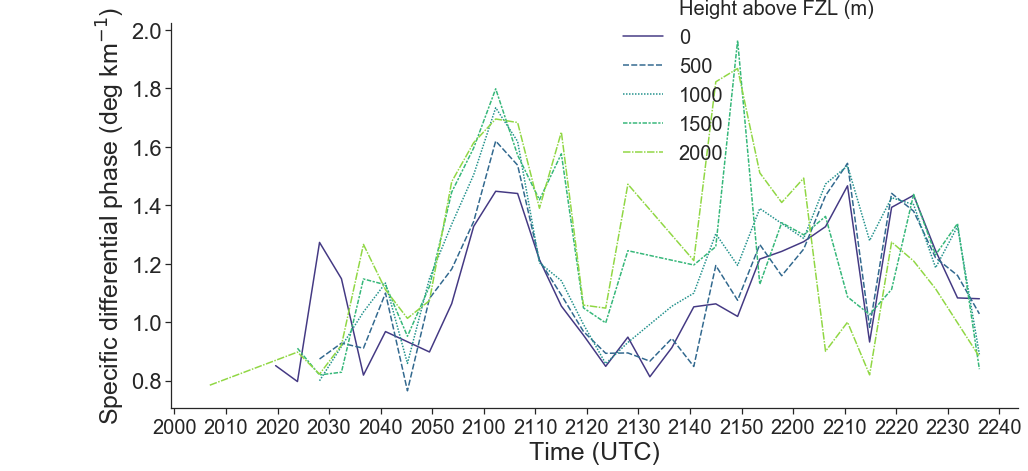

In [43]:
# fig = plt.figure(figsize=(12,12))
g = seaborn.relplot(
    data=full_kdp_prop_alt,
    kind="line",
    hue="Height above FZL (m)",
    hue_order=[0, 500, 1000, 1500, 2000],
    x="time",
    y="kdp",
    palette="viridis",
    style="Height above FZL (m)",
    style_order=[0, 500, 1000, 1500, 2000],
    height=5,
    aspect=1,
    facet_kws=dict(sharex=False),
    ci =None
    #     markers=True
)
g.fig.set_figwidth(40)
g.fig.set_figheight(8)
g.ax.xaxis.set_major_formatter(dates.DateFormatter("%H%M"))
g.ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))

leg = g._legend
leg.set_bbox_to_anchor([0.21, 0.85])  # coordinates of lower left of bounding box
leg._loc = 2  # if required you can set the loc

g.set_ylabels('Specific differential phase (deg km$^{-1}$)')
g.set_xlabels('Time (UTC)')
# plt.tight_layout()
plt.show()